In [59]:
import os

# Check if you're on Google drive or on your own machine.
# Get path to your data.
if ('google' in str(get_ipython())):
    from google.colab import drive
    drive.mount('ME')
    #predir='/content/ME/My Drive/'
    predir='ME/My Drive/'

import torch
import numpy as np

# Torch functions
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import collections
import pickle
import argparse
from random import shuffle
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib.pylab  as plt
#%matplotlib inline


# Folder with course data
datadir=predir+'LSDA_data/NLP/'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)
import time
import numpy as np



Drive already mounted at ME; to attempt to forcibly remount, call drive.mount("ME", force_remount=True).
cuda:0


# Parameters used in code

In [60]:
parser = argparse.ArgumentParser()
parser.add_argument('--data_dir', default=datadir)
parser.add_argument('--save_dir', default='./')
# Dimension of hidden layer variables h and c
parser.add_argument('--num_units', default=128*2)
parser.add_argument('--batch_size', default=64)
# Number of steps in each batch for training
parser.add_argument('--num_steps', default=75)
parser.add_argument('--num_epochs', default=3)
# Time step
parser.add_argument('--lr', default=0.002)
# Number of possible inputs/outputs
parser.add_argument('--num_chars')
parser.add_argument('--num_batches',default=20)
args, unparsed = parser.parse_known_args()

In [61]:
def timer(start, end):
    hrs, rem = divmod(end-start, 3600)
    mins, secs = divmod(rem, 60)
    print('{:0>2} hours {:0>2} minutes {:05.2f} seconds'.format(int(hrs), int(mins), secs))

# Class for handling the text data, creating vocabulary (in this case just the 65 characters). Creating batches and loading batches

In [62]:
class TextLoader():

    def __init__(self, data_dir, batch_size=64, seq_length=50, encoding='utf-8'):
        self.data_dir = data_dir
        self.encoding = encoding
        self.batch_size = batch_size
        self.seq_length = seq_length

        self.input_file = os.path.join(data_dir, 'tinyshakespeare.txt')
        self.vocab_file = os.path.join(data_dir, 'vocab.pkl')
        # Numeric file of characters translated to indices.
        self.tensor_file = os.path.join(data_dir, 'data.npy')

        if not (os.path.exists(self.vocab_file) and os.path.exists(self.tensor_file)):
            #print('it seems we havent processed the text data yet: reading the shakespear')
            self.preprocess(self.input_file, self.vocab_file, self.tensor_file)
        else:
            #print('there are preprocessed data - lets load it')
            self.load_preprocessed(self.vocab_file, self.tensor_file)

        self.create_batches()
        self.reset_batch_pointer()

    # Create numeric file.
    def preprocess(self, input_file=None, vocab_file=None, tensor_file=None, saveit=True):
        if input_file is not None:
            self.input_file = input_file
        if vocab_file is not None:
            self.vocab_file = vocab_file
        if tensor_file is not None:
            self.tensor_file = tensor_file

        with open(self.input_file, 'r') as f:
            data = f.read()
        #data = data.lower()
        self.total_length = len(data)
        counter = collections.Counter(data)
        count_pairs = sorted(counter.items(), key=lambda x: -x[1])
        self.chars, _ = zip(*count_pairs)
        self.vocab_size = len(self.chars)
        self.vocab_to_idx = dict(zip(self.chars, range(len(self.chars))))
        self.idx_to_vocab = dict(zip(self.vocab_to_idx.values(), self.vocab_to_idx.keys()))

        if saveit:
            with open(self.vocab_file, 'wb') as f:  # saving dictionary so we don't compute it again
                pickle.dump(self.chars, f)
            self.tensor = np.array(list(map(self.vocab_to_idx.get, data)))
            np.save(self.tensor_file, self.tensor)  # saving the numerified data
    # Load numeric file create dictionaries for char2idx and back
    def load_preprocessed(self, vocab_file=None, tensor_file=None):
        if vocab_file is not None:
            self.vocab_file = vocab_file
        if tensor_file is not None:
            self.tensor_file = tensor_file

        with open(self.vocab_file, 'rb') as f:
            self.chars = pickle.load(f)

        # attributes
        self.vocab_size = len(self.chars)
        self.vocab = dict(zip(self.chars, range(self.vocab_size)))
        self.vocab_to_idx = dict(zip(self.chars, range(len(self.chars))))
        self.idx_to_vocab = dict(zip(self.vocab_to_idx.values(), self.vocab_to_idx.keys()))
        self.tensor = np.load(tensor_file)
        self.num_batches = int(self.tensor.size / (self.batch_size * self.seq_length))

    # tensor size = the length of the entire data sequence
    # divide into batch_size sub sequences and stack
    # cut those by seq_length to produce batches of [batch size, seq_length] sized examples
    def create_batches(self):


        self.num_batches = int(self.tensor.size / (self.batch_size * self.seq_length))

        if self.num_batches == 0:
            assert False, 'Not enough data. Make seq_length and/or batch_size smaller'

        self.tensor = self.tensor[:self.num_batches * self.batch_size * self.seq_length]  # so we get an even divide
        xdata = self.tensor
        ydata = np.copy(self.tensor)

        # ydata is one step ahead of x and last item is first item of x
        # to get sequences of same length
        ydata[:-1] = xdata[1:]
        ydata[-1] = xdata[0]

        self.x_batches = np.split(xdata.reshape(self.batch_size, -1), self.num_batches, 1)
        self.y_batches = np.split(ydata.reshape(self.batch_size, -1), self.num_batches, 1)

        self.train_num_batches=np.int32(self.num_batches*.8)
        self.test_num_batches=self.num_batches-self.train_num_batches
        self.train_x_batches=self.x_batches[0:self.train_num_batches]
        self.train_y_batches=self.y_batches[0:self.train_num_batches]
        self.test_x_batches=self.x_batches[self.train_num_batches:]
        self.test_y_batches=self.y_batches[self.train_num_batches:]

        # xdata: L length
        # xdata reshaped: batch_size, (L/batch_size) length following natural indexing
        # np.split: into num batches batches along the width(sentence)

    def next_batch_train(self):
        x, y = self.train_x_batches[self.pointer], self.train_y_batches[self.pointer]
        self.pointer += 1
        return x,y

    def next_batch_test(self):
        x, y = self.test_x_batches[self.pointer], self.test_y_batches[self.pointer]
        self.pointer += 1
        return x,y

    def reset_batch_pointer(self):
        self.pointer = 0

In [63]:
loader = TextLoader(args.data_dir, batch_size=args.batch_size, seq_length=args.num_steps)
args.num_chars = loader.vocab_size
print('num chars',args.num_chars)
print('num batches',loader.num_batches)

num chars 65
num batches 232


# Basic RNN

In [64]:
# SimpleRNN Cell Class
class MyBasicRNNCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.W = nn.Parameter(torch.Tensor(input_size + hidden_size, hidden_size))
        self.b = nn.Parameter(torch.Tensor(hidden_size))
        self.init_weights()
    def init_weights(self):
        for p in self.parameters():
            if p.data.ndimension() >= 2:
                nn.init.xavier_uniform_(p.data)
            else:
                nn.init.zeros_(p.data)
    def forward(self, x, init_states):
        output = torch.tanh(torch.cat((x, init_states),1)@self.W + self.b)
        return output, output

# Basic LSTM

In [65]:
class MyBasicLSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.weight_ih = nn.Parameter(torch.Tensor(input_size, hidden_size * 4))
        self.weight_hh = nn.Parameter(torch.Tensor(hidden_size, hidden_size * 4))
        self.bias = nn.Parameter(torch.Tensor(hidden_size * 4))
        self.init_weights()
    def init_weights(self):
        for p in self.parameters():
            if p.data.ndimension() >= 2:
                nn.init.xavier_uniform_(p.data)
            else:
                nn.init.zeros_(p.data)
    def forward(self, x, init_states=None):
        if init_states is None:
            h_t, c_t = (torch.zeros(self.hidden_size).to(x.device),
                        torch.zeros(self.hidden_size).to(x.device))
        else:
            h_t, c_t = init_states
        HS = self.hidden_size
        gates = x @ self.weight_ih + h_t @ self.weight_hh + self.bias
        i_t, f_t, g_t, o_t = (
            torch.sigmoid(gates[:, :HS]), # input
            torch.sigmoid(gates[:, HS:HS*2]), # forget
            torch.tanh(gates[:, HS*2:HS*3]),
            torch.sigmoid(gates[:, HS*3:]), # output
        )
        c_t = f_t * c_t + i_t * g_t
        h_t = o_t * torch.tanh(c_t)
        return h_t, (h_t, c_t)

# Function incorporating chosen Cell type (LSTM, RNN). Unrolling it and adding the loss computation.

In [66]:
class network(nn.Module):
    def __init__(self, cell_type, ntoken, ninp, nhid):
#       cell_type can be RNN or LSTM
#       notken should be args.num_chars
#       ninp should be args.num_units - it is the dimension of the embedding
#       of the discrete tokens and it usually the same as the hidden dimension.
#       nhid should be args.num_units
        super(network, self).__init__()
        self.cell_type = cell_type
        if self.cell_type == 'LSTM':
            self.cell = MyBasicLSTMCell(args.num_units, args.num_units)

        elif self.cell_type == 'RNN':
            self.cell = MyBasicRNNCell(args.num_units, args.num_units)
        else:
            raise NotImplementedError
        self.ntoken = ntoken
        self.ninp = ninp
        self.nhid = nhid
        self.embedding = nn.Embedding(ntoken, ninp)
        self.decoder = nn.Linear(nhid, ntoken)
        self.init_weights()

    def init_weights(self):
        self.decoder.bias.data.zero_()

    def forward(self, x, hidden):
        bs, seq_sz = x.size()
        emb = self.embedding(x)
        assert hidden is not None
        outputs = []
        for t in range(seq_sz):
            x_t = emb[:,t,:]
            output, hidden = self.cell(x_t, hidden)
            outputs.append(output)
        reshaped_output = torch.cat(outputs,1).view(-1, self.nhid)
        logits = self.decoder(reshaped_output)
        logits = logits.view(bs,seq_sz,-1)
        final_hidden = hidden
        return logits, final_hidden

    def init_hidden(self, bsz):
        # external function
        weight = next(self.parameters()).data
        if self.cell_type == 'LSTM':
            return (weight.new_zeros(bsz, self.nhid),
                    weight.new_zeros(bsz, self.nhid))
        elif self.cell_type == 'RNN':
            return weight.new_zeros(bsz, self.nhid)
        else:
            raise NotImplementedError

# Train

In [67]:

def trainer(celltype):
    criterion = nn.CrossEntropyLoss()
    start_time = time.time()
    my_network = network(celltype, args.num_chars, args.num_units, args.num_units).to(device)
    my_network.train()
    optimizer = torch.optim.Adam(my_network.parameters(), lr=args.lr)
    print('train_num_batches',loader.train_num_batches)

    num_batches=loader.train_num_batches
    training_losses = []
    for epoch in range(args.num_epochs):
        loader.reset_batch_pointer()
        # Initial state - 0
        init_state = my_network.init_hidden(args.batch_size)
        training_loss = 0

        for batch in range(num_batches):
            x, y = loader.next_batch_train()
            x = torch.from_numpy(np.int64(x)).to(device)
            y = Variable(torch.from_numpy(np.int64(y))).to(device)
            preds, final_hidden = my_network(x, init_state)
            train_loss_ = criterion(preds.reshape(-1, args.num_chars), y.reshape(-1))
            optimizer.zero_grad()
            train_loss_.backward()
            optimizer.step()
            training_loss += train_loss_.item()
        training_loss=training_loss/num_batches
        print('epoch:', epoch, 'loss:',  training_loss)
        training_losses.append(training_loss)
    torch.save(my_network.state_dict(), os.path.join(args.save_dir, f'saved_{celltype}_model.pt'))
    end_time = time.time()

    timer(start_time, end_time)
    return(training_losses)

In [45]:
print(device)
args.num_epochs=20
re_lstm_basic = trainer("LSTM")

cuda:0
train_num_batches 185
epoch: 0 loss: 2.1145383963713775
epoch: 1 loss: 1.6736715928928272
epoch: 2 loss: 1.5621705010130598
epoch: 3 loss: 1.502823126638258
epoch: 4 loss: 1.4637137477462356
epoch: 5 loss: 1.4347732698595201
epoch: 6 loss: 1.4121664131009901
epoch: 7 loss: 1.3939248594077858
epoch: 8 loss: 1.3784955772193703
epoch: 9 loss: 1.3648446418143607
epoch: 10 loss: 1.3526634254971066
epoch: 11 loss: 1.341670407475652
epoch: 12 loss: 1.331702216895851
epoch: 13 loss: 1.3225789366541683
epoch: 14 loss: 1.3143368237727397
epoch: 15 loss: 1.3068000045982566
epoch: 16 loss: 1.2998268823365908
epoch: 17 loss: 1.2935911610319808
epoch: 18 loss: 1.2874319869118769
epoch: 19 loss: 1.2817939706750818
00 hours 04 minutes 02.87 seconds


In [13]:
print(device)
args.num_epochs=20
re_rnn_basic = trainer("RNN")

cuda:0
train_num_batches 185
epoch: 0 loss: 2.0746412148346773
epoch: 1 loss: 1.7169060694204794
epoch: 2 loss: 1.6212332306681452
epoch: 3 loss: 1.5696536193022856
epoch: 4 loss: 1.536439197772258
epoch: 5 loss: 1.513077710770272
epoch: 6 loss: 1.4951605255539353
epoch: 7 loss: 1.4810175012897802
epoch: 8 loss: 1.469540643047642
epoch: 9 loss: 1.460003560298198
epoch: 10 loss: 1.4518935886589257
epoch: 11 loss: 1.4448576134604376
epoch: 12 loss: 1.4386945956462138
epoch: 13 loss: 1.4331296669470297
epoch: 14 loss: 1.4283275694460482
epoch: 15 loss: 1.424188122233829
epoch: 16 loss: 1.4206270920263755
epoch: 17 loss: 1.4172512814805314
epoch: 18 loss: 1.4145558402344987
epoch: 19 loss: 1.4118384200173455
00 hours 01 minutes 34.78 seconds


# Reload model and run a simulated prediction

In [14]:
def Synthesize(celltype, init_string="None"):
    num_steps_bak=args.num_steps
    batch_size_bak=args.batch_size
    args.num_steps=1
    args.batch_size=1
    my_network = network(celltype, args.num_chars, args.num_units, args.num_units)
    my_network.load_state_dict(torch.load(os.path.join(args.save_dir, f'saved_{celltype}_model.pt')))
    my_network.eval()

    # Define initialization
    if (init_string is None):
        initialization = 'Where are you going today?'
    else:
        initialization = init_string
    loader= TextLoader(args.data_dir, batch_size=1, seq_length=1)

    forecast_data=np.array(list(map(loader.vocab_to_idx.get, initialization)))
    #print(forecast_data)
    forecast_range = 100
    top_k=5

    # Run rnn on initialization data to get final hidden state before simulation
    init_state = my_network.init_hidden(args.batch_size)
    #print('data length',forecast_data.shape[0])
    with torch.no_grad():
        for i in range(forecast_data.shape[0]):
            inputs = forecast_data[i].reshape(args.batch_size, args.num_steps)
            x = Variable(torch.from_numpy(np.int64(inputs)))
            _, state_ = my_network(x, init_state)

        # last state of this step becomes first state of simulation

        for i in range(forecast_range):
            # Feed current predicted
            inputs = forecast_data[-args.num_steps:].reshape(args.batch_size, args.num_steps)
            x = Variable(torch.from_numpy(np.int64(inputs)))
            logits_, state_ = my_network(x, state_)
            predicted_prob = F.softmax(logits_.reshape(-1, args.num_chars),1).detach().numpy().squeeze()
#             print(predicted_prob.shape)
            # Simulate from top top_k probs
            predicted_prob[np.argsort(predicted_prob)[:-top_k]] = 0
            predicted_prob = predicted_prob/np.sum(predicted_prob)
            sample = np.random.choice(args.num_chars, 1, p=predicted_prob)[0]
            forecast_data = np.hstack((forecast_data, sample))

    forecasted_chars = np.asarray([loader.idx_to_vocab[elem] for elem in forecast_data])

    print(''.join(forecasted_chars))

    args.num_steps=num_steps_bak
    args.batch_size=batch_size_bak

In [15]:
Synthesize("LSTM","I am trying to create synthetic language, and its probably not working well, What is the meaning of life ")

I am trying to create synthetic language, and its probably not working well, What is the meaning of life our father sailous
And my husband's sin is beasts which I
Whom I do not blown of tears,
And there at


In [16]:
Synthesize("RNN","I am trying to create synthetic language, and its probably not working well, What is the meaning of life ")

I am trying to create synthetic language, and its probably not working well, What is the meaning of life an orthrave bettake of my seven tiger seemis welcome.

DUCHESS OF YORK:
Have been that is no leaves 


# Get loss on test set

In [17]:
def Tester(celltype, num_batches=None):
    my_network = network(celltype, args.num_chars, args.num_units, args.num_units)
    my_network.load_state_dict(torch.load(os.path.join(args.save_dir, f'saved_{celltype}_model.pt')))
    my_network.eval()
    # Define initialization
    initialization = 'Where are you going today?'
    loader= TextLoader(args.data_dir, batch_size=args.batch_size, seq_length=args.num_steps)

    forecast_data=np.array(list(map(loader.vocab_to_idx.get, initialization)))
    print(forecast_data)
    forecast_range = 100
    top_k=5

    if (num_batches is None):
        num_batches=loader.test_num_batches

    state_ = my_network.init_hidden(args.batch_size)
    loader.reset_batch_pointer()
    # Get test error loss
    test_loss = 0
    print('num_batches',num_batches)
    criterion = nn.CrossEntropyLoss()
    with torch.no_grad():
        for batch in range(num_batches):
            x, y = loader.next_batch_test()
            x = Variable(torch.from_numpy(np.int64(x)))
            y = Variable(torch.from_numpy(np.int64(y)))
            preds, final_hidden = my_network(x, state_)
            test_loss_ = criterion(preds.reshape(-1, args.num_chars), y.reshape(-1))
            test_loss += test_loss_.item()
        test_loss=test_loss/num_batches
        print('test loss:',  test_loss)

    return(test_loss)

(a)

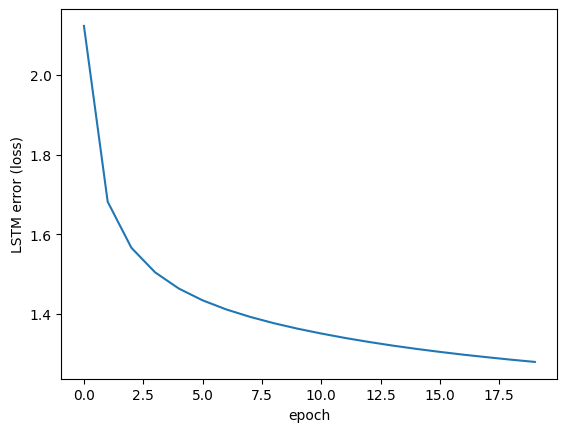

In [18]:
import matplotlib.pyplot as plt

epoch = [i for i in range(20)]
plt.plot(epoch, re_lstm_basic)
plt.xlabel('epoch')
plt.ylabel('LSTM error (loss)')
plt.show()

In [19]:
Synthesize("LSTM", "Once upon a time, ")
Synthesize("LSTM", "we are poor citizens.")

Once upon a time, old
The bottom flines it is a banishment in their son is thy father
Would not be a traitor and seem 
we are poor citizens.

BRUTUS:
We should have be an house is as teached brave his command
And say you he hath doth be die


In [20]:
Tester('LSTM')

[39  5  1  7  1  0  4  7  1  0 15  3 13  0 20  3  9  8 20  0  2  3 12  4
 15 44]
num_batches 47
test loss: 1.4338286531732438


1.4338286531732438

(b)

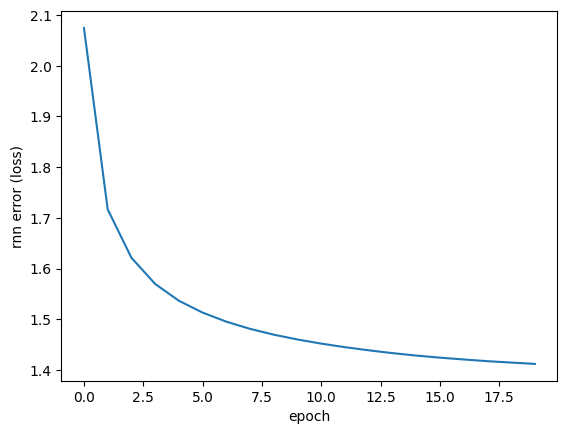

In [21]:
epoch = [i for i in range(20)]
plt.plot(epoch, re_rnn_basic)
plt.xlabel('epoch')
plt.ylabel('rnn error (loss)')
plt.show()

In [22]:
Synthesize("RNN", "once upon a time, ")
Synthesize("RNN", "We are poor citizens.")

once upon a time, and more
That true
Is a banishment
Have did the closes manners there is this is too blood's son: but
We are poor citizens.

PRINCE EDWARD:
Not a pretty those
That well be some our good blozk!

Clown:
A privil's blown; and 


In [23]:
Tester('RNN')

[39  5  1  7  1  0  4  7  1  0 15  3 13  0 20  3  9  8 20  0  2  3 12  4
 15 44]
num_batches 47
test loss: 1.4970180354219802


1.4970180354219802

We get a slightly higher loss

(c), (d)

alternative 1: Set the parameter values for the RNN to be the same as those for the LSTM.

Number of parameters (RNN) = $I\times H+H\times H+H$

number of parameters (LSTM) = $4\times (I\times H + H\times H + H)$

For this model I=H. Approximately we can use 256 input size (which is default) for RNN and 128 input size for LSTM.

In [68]:
print(device)
args.num_epochs = 5
re_rnn_basic = trainer("RNN")
args.num_units = 128
re_lstm_basic = trainer("LSTM")


cuda:0
train_num_batches 185
epoch: 0 loss: 2.071279949755282
epoch: 1 loss: 1.718276748141727
epoch: 2 loss: 1.6246051517692772
epoch: 3 loss: 1.5735226972683056
epoch: 4 loss: 1.5403292320870063
00 hours 00 minutes 29.23 seconds
train_num_batches 185
epoch: 0 loss: 2.395808404200786
epoch: 1 loss: 1.8949029522973138
epoch: 2 loss: 1.7553787463420145
epoch: 3 loss: 1.675557904630094
epoch: 4 loss: 1.6252351838189203
00 hours 01 minutes 15.81 seconds


For the same amount of parameters, LSTM seems to be less effective.

In [71]:
rnn_losses = [2.071279949755282, 1.718276748141727, 1.6246051517692772, 1.5735226972683056, 1.5403292320870063]
lstm_losses = [2.395808404200786, 1.8949029522973138, 1.7553787463420145, 1.675557904630094, 1.6252351838189203]

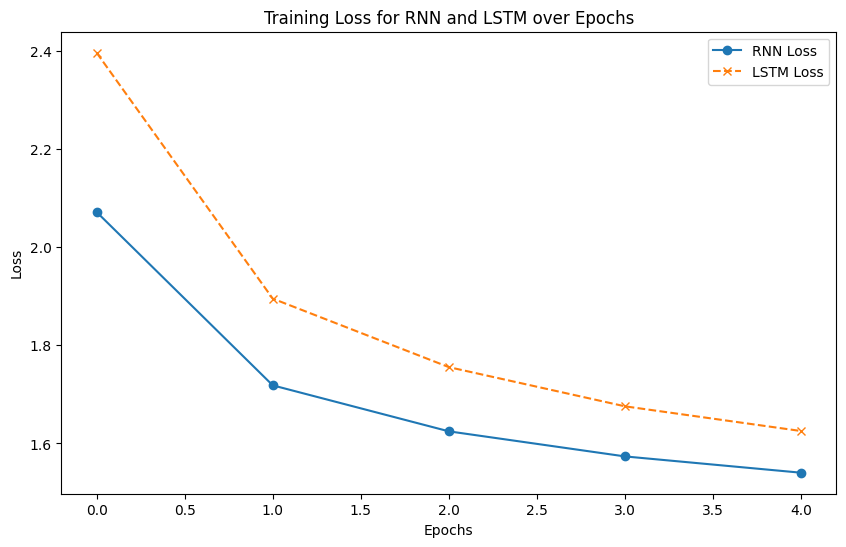

In [72]:
import matplotlib.pyplot as plt

# Assuming your epochs start from 0 and go to 4
epochs = [0, 1, 2, 3, 4]

# Plotting the loss values for RNN and LSTM
plt.figure(figsize=(10, 6))
plt.plot(epochs, rnn_losses, marker='o', linestyle='-', label='RNN Loss')
plt.plot(epochs, lstm_losses, marker='x', linestyle='--', label='LSTM Loss')

# Adding labels and title
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss for RNN and LSTM over Epochs')

# Adding a legend to specify which line corresponds to RNN and which to LSTM
plt.legend()

# Display the plot
plt.show()


In [30]:
args.num_units = 256
Synthesize("RNN", "once upon a time, ")
Synthesize("RNN", "We are poor citizens.")

once upon a time, impossion:
But, was the been that we was not bear the stay now not that says this be made to the bod
We are poor citizens.

DUCHIUS:
Ay, assent once woman.

KING EDWASHAS:
Now, by his lords,
To how had be and by the will n


In [32]:
args.num_units = 128
Synthesize("LSTM", "once upon a time, ")
Synthesize("LSTM", "We are poor citizens.")

once upon a time, this sons, be must.

KING HENRY VI:
Neatce her he watest of mine on to them.
When, sir, she worse to
We are poor citizens.

CORIOLANUS:
We'er till the storned, and, but I shing their was them,
That some him.

KING ELIZABLA


alternative 2: change the dimension of input for both RNN and LSTM to 512 (epoch 10)

In [46]:
print(device)
args.num_epochs = 10
args.num_units = 512
re_rnn_basic = trainer("RNN")
re_lstm_basic = trainer("LSTM")

cuda:0
train_num_batches 185
epoch: 0 loss: 1.9151248332616446
epoch: 1 loss: 1.61130091370763
epoch: 2 loss: 1.5315747003297548
epoch: 3 loss: 1.488020051492227
epoch: 4 loss: 1.4597355172440813
epoch: 5 loss: 1.4395938209585242
epoch: 6 loss: 1.4233654763247516
epoch: 7 loss: 1.4104436977489574
epoch: 8 loss: 1.3995379815230498
epoch: 9 loss: 1.3912924244597151
00 hours 01 minutes 13.73 seconds
train_num_batches 185
epoch: 0 loss: 1.9314522298606667
epoch: 1 loss: 1.5580413083772402
epoch: 2 loss: 1.4663102903881589
epoch: 3 loss: 1.4147661009350339
epoch: 4 loss: 1.378632115029
epoch: 5 loss: 1.3499600358911463
epoch: 6 loss: 1.3264180666691547
epoch: 7 loss: 1.3051689747217539
epoch: 8 loss: 1.2862817223007614
epoch: 9 loss: 1.2693225635064616
00 hours 02 minutes 21.91 seconds


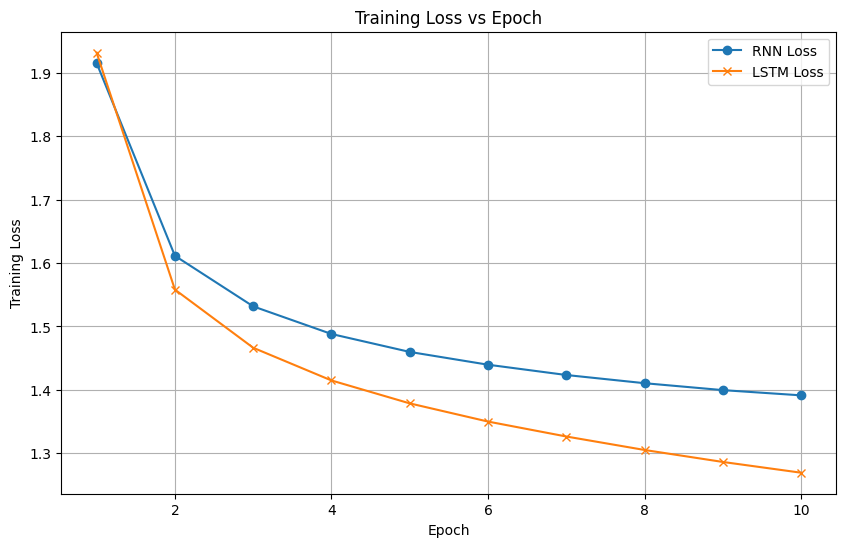

In [47]:
import matplotlib.pyplot as plt

# Given epoch losses
rnn_losses = [1.9151248332616446, 1.61130091370763, 1.5315747003297548, 1.488020051492227, 1.4597355172440813, 1.4395938209585242, 1.4233654763247516, 1.4104436977489574, 1.3995379815230498, 1.3912924244597151]
lstm_losses = [1.9314522298606667, 1.5580413083772402, 1.4663102903881589, 1.4147661009350339, 1.378632115029, 1.3499600358911463, 1.3264180666691547, 1.3051689747217539, 1.2862817223007614, 1.2693225635064616]
epochs = list(range(1, len(rnn_losses) + 1))

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(epochs, rnn_losses, label='RNN Loss', marker='o')
plt.plot(epochs, lstm_losses, label='LSTM Loss', marker='x')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss vs Epoch')
plt.legend()
plt.grid(True)
plt.show()

In [48]:
Synthesize("RNN", "once upon a time, ")
Synthesize("RNN", "We are poor citizens.")

once upon a time, the common to-morrow.

AUTOLYCUS:
O God between to be sparest in their prince with hurst he speak an
We are poor citizens.

PROSPERO:

Provost:
Hate another mistill is are now,
And we were where as to be see as that I what


In [49]:
Synthesize("LSTM", "once upon a time, ")
Synthesize("LSTM", "We are poor citizens.")

once upon a time, our curses at that to make made all.

COMINIUS:
Now we lie, I did not, so man.

SICINIUS:
Nay, that 
We are poor citizens.

SICINIUS:
We will not so, in tempest it in the cause.

All Servingman:
Wilt then trust me, to bear


alternative 3: add a hidden layer on RNN

In [73]:
class MyTwoLayerRNNCell(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=2):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.rnn_cells = nn.ModuleList([MyBasicRNNCell(input_size if i == 0 else hidden_size, hidden_size) for i in range(num_layers)])

    def init_weights(self):
        for cell in self.rnn_cells:
            cell.init_weights()

    def forward(self, x, init_states=None):
        if init_states is None:
            init_states = [torch.zeros(self.hidden_size).to(x.device) for _ in range(self.num_layers)]

        outputs = []
        new_states = []

        h_t = x
        for i, (cell, h_init) in enumerate(zip(self.rnn_cells, init_states)):
            h_t, new_state = cell(h_t, h_init)
            outputs.append(h_t)
            new_states.append(new_state)

        return outputs[-1], new_states

In [74]:
class network(nn.Module):
    def __init__(self, cell_type, ntoken, ninp, nhid, num_layers=2):
        super(network, self).__init__()
        self.cell_type = cell_type
        self.num_layers = num_layers
        if self.cell_type == 'LSTM':
            self.cell = MyBasicLSTMCell(args.num_units, args.num_units)  # Assuming you have a MyBasicLSTMCell class
        elif self.cell_type == 'RNN':
            self.cell = MyTwoLayerRNNCell(args.num_units, args.num_units, num_layers=self.num_layers)
        else:
            raise NotImplementedError
        self.ntoken = ntoken
        self.ninp = ninp
        self.nhid = nhid
        self.embedding = nn.Embedding(ntoken, ninp)
        self.decoder = nn.Linear(nhid, ntoken)
        self.init_weights()

    def init_weights(self):
        self.decoder.bias.data.zero_()

    def forward(self, x, hidden):
        bs, seq_sz = x.size()
        emb = self.embedding(x)
        assert hidden is not None
        outputs = []
        for t in range(seq_sz):
            x_t = emb[:, t, :]
            output, hidden = self.cell(x_t, hidden)
            outputs.append(output)
        reshaped_output = torch.cat(outputs, 1).view(-1, self.nhid)
        logits = self.decoder(reshaped_output)
        logits = logits.view(bs, seq_sz, -1)
        final_hidden = hidden[-1]  # Take the hidden state from the last layer
        return logits, final_hidden

    def init_hidden(self, bsz):
        weight = next(self.parameters()).data
        if self.cell_type == 'LSTM':
            return (weight.new_zeros(bsz, self.nhid),
                    weight.new_zeros(bsz, self.nhid))
        elif self.cell_type == 'RNN':
            return [weight.new_zeros(bsz, self.nhid) for _ in range(self.num_layers)]  # Initialize for each layer
        else:
            raise NotImplementedError

In [75]:
re_rnn_basic = trainer("RNN")
re_lstm_basic = trainer("LSTM")

train_num_batches 185
epoch: 0 loss: 2.2148949642439146
epoch: 1 loss: 1.776974130965568
epoch: 2 loss: 1.667539198978527
epoch: 3 loss: 1.6093443992975596
epoch: 4 loss: 1.5719408363909335
00 hours 00 minutes 48.19 seconds
train_num_batches 185
epoch: 0 loss: 2.385638726079786
epoch: 1 loss: 1.8814494075001897
epoch: 2 loss: 1.7422591679805033
epoch: 3 loss: 1.6676008153606106
epoch: 4 loss: 1.6190231226586007
00 hours 01 minutes 19.66 seconds


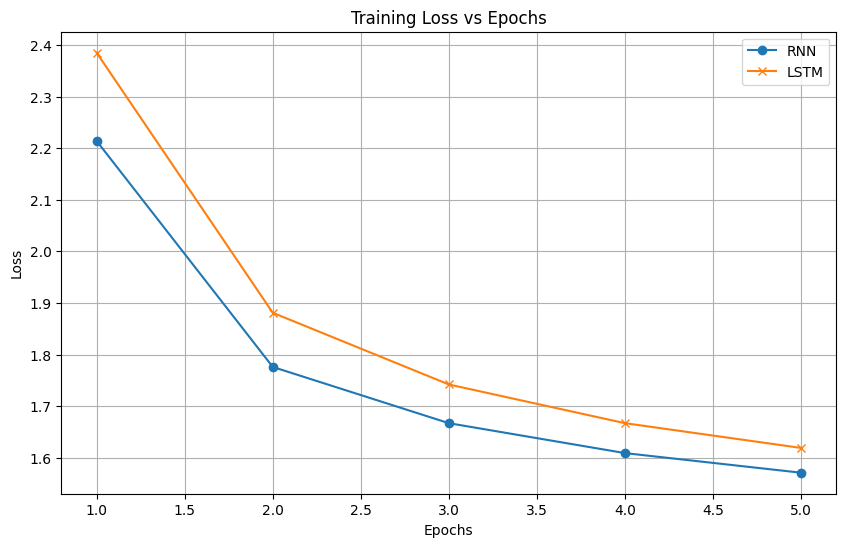

In [76]:
import matplotlib.pyplot as plt

# Your data
epochs = [1, 2, 3, 4, 5]
model1_loss = [2.214, 1.776, 1.667, 1.609, 1.571]
model2_loss = [2.385, 1.881, 1.742, 1.667, 1.619]

# Plotting
plt.figure(figsize=(10,6))
plt.plot(epochs, model1_loss, label='RNN', marker='o')
plt.plot(epochs, model2_loss, label='LSTM', marker='x')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss vs Epochs')
plt.legend()
plt.grid(True)
plt.show()


Problem 2

(a)

In [ ]:
import pickle

from google.colab import drive
drive.mount('/content/drive')

with open('/content/drive/My Drive/LSDA_data/Speech/SOUND_DATA_A', 'rb') as f:
    data = pickle.load(f)

Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn

X_train = torch.tensor(data.get('X_train_mfcc'))
Y_train = torch.tensor(data.get('Y_train'))
X_test = torch.tensor(data.get('X_test_mfcc'))
Y_test = torch.tensor(data.get('Y_test'))

In [ ]:
import torch
import torch.nn as nn

# Define the RNN model
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNNModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])
        return out

# Hyperparameters
input_size = 64
hidden_size = 128
num_layers = 2
num_classes = 10
num_epochs = 10
learning_rate = 0.001
batch_size = 100

# Prepare data for training
train_dataset = torch.utils.data.TensorDataset(X_train, Y_train)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Prepare data for testing
test_dataset = torch.utils.data.TensorDataset(X_test, Y_test)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Initialize the RNN
model = RNNModel(input_size, hidden_size, num_layers, num_classes)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()  # updated loss function
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    for i, (inputs, labels) in enumerate(train_dataloader):
        inputs = inputs.float()
        labels = labels.long()  # Ensure labels are LongTensor
        outputs = model(inputs)
        loss = criterion(outputs, labels.squeeze())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_dataloader)}], Loss: {loss.item()}')

# Test the model
model.eval()
total = 0
correct = 0
with torch.no_grad():
    for inputs, labels in test_dataloader:
        inputs = inputs.float()
        labels = labels.long()  # Ensure labels are LongTensor
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)  # Get the class with highest score
        total += labels.size(0)
        correct += (predicted == labels.squeeze()).sum().item()

print('Test Accuracy of the model on the test data: {:.2f}%'.format(100 * correct / total))

Epoch [1/10], Step [10/15], Loss: 2.2939422130584717
Epoch [2/10], Step [10/15], Loss: 2.1847028732299805
Epoch [3/10], Step [10/15], Loss: 1.9196614027023315
Epoch [4/10], Step [10/15], Loss: 1.688099980354309
Epoch [5/10], Step [10/15], Loss: 1.1679259538650513
Epoch [6/10], Step [10/15], Loss: 0.9805996417999268
Epoch [7/10], Step [10/15], Loss: 0.6854565143585205
Epoch [8/10], Step [10/15], Loss: 0.5235242247581482
Epoch [9/10], Step [10/15], Loss: 0.48042362928390503
Epoch [10/10], Step [10/15], Loss: 0.35656148195266724
Test Accuracy of the model on the test data: 86.80%


(b)

In [ ]:
import torch
import torch.nn as nn

X_train = torch.tensor(data.get('X_train_mfcc'))
Y_train = torch.tensor(data.get('Y_train'))
X_test = torch.tensor(data.get('X_test_mfcc'))
Y_test = torch.tensor(data.get('Y_test'))

In [ ]:
import torch
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Assuming your input data is X and labels are Y
X = X_train
Y = Y_train

# Reshape the input data and convert to numpy array
X = X.view(1500, -1).numpy()

# Convert labels to numpy array
Y = Y.numpy()

# Flatten the labels
Y = Y.ravel()

# Initialize the Logistic Regression model
model = LogisticRegression()

# Fit the model to the training data
model.fit(X, Y)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [ ]:
import torch
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Assuming your input data is X and labels are Y
X = X_test
Y = Y_test

# Reshape the input data and convert to numpy array
X = X.view(750, -1).numpy()

# Convert labels to numpy array
Y = Y.numpy()

# Flatten the labels
Y = Y.ravel()

# Initialize the Logistic Regression model
model = LogisticRegression()

# Fit the model to the training data
model.fit(X, Y)

# Predict the labels for the training data
Y_pred = model.predict(X)

# Compute the accuracy on the training data
accuracy = accuracy_score(Y, Y_pred)

print(f'Training accuracy: {accuracy * 100.0:.2f}%')

Training accuracy: 100.00%


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


(c)

I got 83.60% accuracy for RNN method and 100% for logistic method.
Computationally intensive model does not necessarily lead to higher accuracy.